In [1]:
import numpy as np
import my_lib.functional as F

np.set_printoptions(3)

In [2]:
num_steps = 1000
steps = np.linspace(0, num_steps)

linear_s = np.stack([
    F.linear_progress(steps, num_steps, progression_range=(0.2, 0.3)),
    F.linear_decay_progress(steps, num_steps, progression_range=(0.1, 0.9))
])

squared_s = np.stack([
    F.squared_progress(steps, num_steps, progression_range=(0.4, 0.75)),
    1 - F.squared_progress(steps, num_steps, progression_range=(0.4, 0.75)),
    F.squared_decay_progress(steps, num_steps, progression_range=(0.4, 0.75)),
    1 - F.squared_decay_progress(steps, num_steps, progression_range=(0.4, 0.75))
])

polynom_s = np.stack([
    F.polynomial_progress(steps, num_steps, 5, (2, 5), progression_range=(0.5, 0.8)),
    F.polynomial_decay_progress(steps, num_steps, 10, (0, 3), progression_range=(0.2, 0.8)),
])

all_s = [linear_s, squared_s, polynom_s]

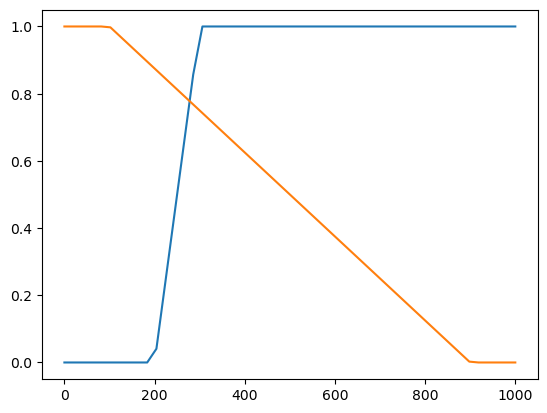

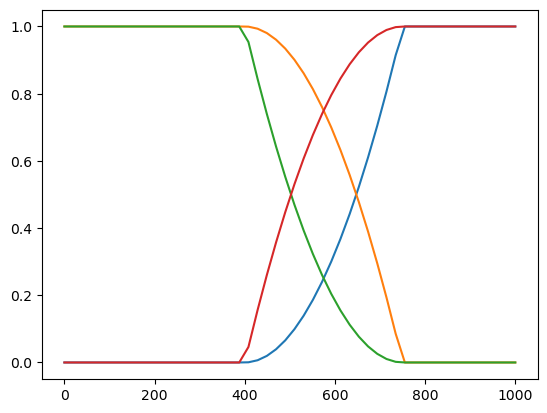

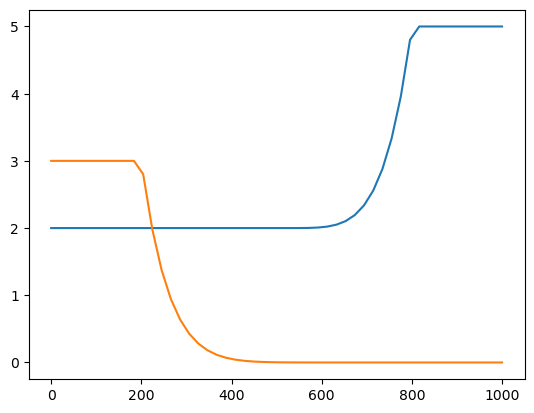

In [3]:
import matplotlib.pyplot as plt

for type_s in all_s:
    for s in type_s: plt.plot(steps, s)
    plt.show()

## Scheduler object

In [4]:
from my_lib.scheduler import Scheduler
import torch

Use the scheduler object in train loops.

In [5]:
epochs = 10

dl = range(100)
scheduler = Scheduler(epochs)

for epoch in range(epochs):
    # train_one_epoch(..., scheduler)
    scheduler.step()

You may also iterate:

In [6]:
scheduler = Scheduler(epochs, type='polynomial-decay', exponent=3)

for epoch, scale in zip(range(epochs), scheduler):
    print(scale)
    ...
    # loss, reward = train_one_epoch(...)
    # scaled_reward = scale * reward
    # or
    # ... = train_one_epoch(..., scale)

1.0
0.7023319615912207
0.4705075445816187
0.2962962962962964
0.1714677640603567
0.08779149519890259
0.03703703703703705
0.010973936899862823
0.001371742112482855
0.0


You may ask yourself why the value decreases by `1/9` not `1/10`. Schedulers work like `np.linspace` not like `np.arange`; `range` functions don't actually reach the upper bound, `linspace` does.

The following example is from a reinforcement learning task using PPO on GPT2 to learn arithmetic operations.

In [7]:
class RewardComputer:
    def __init__(self, num_steps, max_error,
          perfect_bonus_range=(1, 4),
          min_reward=-1, max_reward=1,
          perfect_bonus_progression_range=(.5, .9),
          mse_coef_progression_range=(.1, .7)):
        self.min_reward = min_reward
        self.max_reward = max_reward

        self.perfect_bonus_scheduler = Scheduler(num_steps,
                                                 perfect_bonus_range,
                                                 perfect_bonus_progression_range,
                                                 type='squared')
        self.mse_coef_scheduler = Scheduler(num_steps,
                                            (0, max_error),
                                            mse_coef_progression_range,
                                            type='squared-decay')

        self.max_error = max_error

    def step(self):
        self.perfect_bonus_scheduler.step()
        self.mse_coef_scheduler.step()

    def __call__(self, predictions, solutions):
        mae = abs(predictions - solutions).float()
        reward = (1 - (mae / self.mse_coef_scheduler()) ** 2).clamp(-1, 1)

        mae = torch.where(mae.isnan(), self.max_error, mae).clamp(max=self.max_error)
        reward = torch.where(mae == 0, 1 + self.perfect_bonus_scheduler(), reward)
        reward = torch.where(reward.isnan(), -2, reward)

        return mae, reward / 2